In [ ]:
!nvidia-smi

In [2]:
%matplotlib inline
################################################################################
import os
import numpy as np
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, GRU
from typing import Tuple, Callable, List, Optional
from tracker import visuals, extractor, utils, metrics

np.set_printoptions(suppress=True, precision=2)
np.set_printoptions(edgeitems=20)
Tensor = theano.tensor.Tensor

Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0B:00.0)
Using Theano backend.


In [5]:
f = pd.DataFrame(columns=("A", "B"), data=np.array([[0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0], [0, 1], [1, 0] ]))
f

,A,B
0,0,1
1,1,0
2,0,1
3,1,0
4,0,1
5,1,0
6,0,1
7,1,0


In [2]:
################################################################################
def get_data(
        num_vectors : int,
        vector_size : int = 10,
        min_value   : int = 0,
        max_value   : int = 9,
        ) -> np.ndarray:
    return np.random.randint(min_value, max_value, (num_vectors, vector_size))

def get_output(data : np.ndarray) -> np.ndarray:
    sums = data.sum(axis=1, keepdims=True) - data
    return np.concatenate((data, sums), axis=1)

np.random.seed(1010)
data = get_data(num_vectors=4096)
output = get_output(data)
val_data = get_data(num_vectors=512)
val_output = get_output(val_data)
print("=== Input Matrix ===\n{}".format(data))
print("\n=== Output Matrix ===\n{}".format(output))

=== Input Matrix ===
[[4 8 2 5 3 6 2 1 5 0]
 [6 8 1 8 0 1 5 7 6 3]
 [8 3 5 8 6 2 5 2 5 1]
 [7 1 5 0 1 0 1 3 8 8]
 [8 8 8 7 3 6 2 3 4 6]
 [0 4 7 2 4 8 1 1 7 1]
 [1 8 7 1 2 1 7 7 4 5]
 [3 5 5 6 6 8 0 0 2 7]
 [7 6 1 3 6 5 8 1 2 6]
 [5 5 5 0 1 7 5 0 4 5]
 [3 7 4 8 6 3 5 5 2 6]
 [7 0 8 6 5 2 0 4 3 8]
 [5 7 2 3 6 6 2 2 7 7]
 [2 8 0 0 8 1 1 8 0 8]
 [8 0 3 3 2 0 6 3 6 4]
 [2 5 0 5 0 7 5 5 4 0]
 [8 6 0 4 2 5 2 8 8 7]
 [1 1 8 2 0 8 2 0 5 4]
 [8 6 4 7 2 1 1 8 0 2]
 [1 3 0 6 3 7 7 2 4 1]
 ..., 
 [2 8 7 2 6 7 4 0 3 3]
 [6 1 2 6 1 2 8 8 1 2]
 [0 4 8 3 1 3 6 8 5 7]
 [1 1 4 5 5 7 7 8 8 1]
 [2 5 5 0 6 8 5 1 7 2]
 [7 3 6 8 6 8 4 8 0 0]
 [1 5 1 0 3 0 2 3 8 4]
 [3 5 4 2 4 8 5 2 6 7]
 [0 7 1 3 5 7 2 0 8 6]
 [6 5 3 0 7 7 4 5 4 8]
 [1 8 4 4 7 8 2 5 6 7]
 [7 7 3 8 2 3 3 3 7 4]
 [2 0 0 6 7 1 3 5 8 3]
 [8 2 8 6 6 4 0 7 6 4]
 [3 8 7 6 2 8 4 6 1 5]
 [6 6 7 0 1 6 8 4 1 8]
 [5 4 0 7 4 5 0 8 5 1]
 [1 5 5 7 0 5 1 3 4 8]
 [3 8 6 6 8 6 5 3 8 2]
 [2 7 5 0 0 5 0 0 0 6]]

=== Output Matrix ===
[[ 4  8  2  5  3  6  2  1  5

### Loss is purely the built-in mean squared error

In [3]:
################################################################################
input_layer  = Input(name="Input", shape=data.shape[1:])
model_layer  = Dense(name="Dense 1", units=512, activation="relu")(input_layer)
model_layer  = Dense(name="Dense 2", units=512, activation="relu")(model_layer)
model_layer  = Dense(name="Dense 3", units=512, activation="relu")(model_layer)
output_layer = Dense(name="Output", units=output.shape[1])(model_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10)                0         
_________________________________________________________________
Dense 1 (Dense)              (None, 512)               5632      
_________________________________________________________________
Dense 2 (Dense)              (None, 512)               262656    
_________________________________________________________________
Dense 3 (Dense)              (None, 512)               262656    
_________________________________________________________________
Output (Dense)               (None, 20)                10260     
Total params: 541,204
Trainable params: 541,204
Non-trainable params: 0
_________________________________________________________________


In [4]:
################################################################################
np.random.seed(1010)
histories = model.fit(data, output, epochs=64, batch_size=1, verbose=2,
                     validation_data=(val_data, val_output))

Train on 4096 samples, validate on 512 samples
Epoch 1/64
4s - loss: 3.0026 - acc: 0.6863 - val_loss: 0.1132 - val_acc: 0.8418
Epoch 2/64
4s - loss: 0.7184 - acc: 0.7158 - val_loss: 1.8236 - val_acc: 0.6719
Epoch 3/64
4s - loss: 0.5467 - acc: 0.7263 - val_loss: 0.1713 - val_acc: 0.7148
Epoch 4/64
4s - loss: 0.3611 - acc: 0.7380 - val_loss: 0.1943 - val_acc: 0.7031
Epoch 5/64
4s - loss: 0.3214 - acc: 0.7292 - val_loss: 0.3797 - val_acc: 0.7031
Epoch 6/64
4s - loss: 0.2727 - acc: 0.7422 - val_loss: 0.2971 - val_acc: 0.6445
Epoch 7/64
4s - loss: 0.2439 - acc: 0.7307 - val_loss: 0.0451 - val_acc: 0.7656
Epoch 8/64
4s - loss: 0.1895 - acc: 0.7410 - val_loss: 0.0199 - val_acc: 0.7480
Epoch 9/64
4s - loss: 0.1581 - acc: 0.7373 - val_loss: 0.0270 - val_acc: 0.8105
Epoch 10/64
4s - loss: 0.1581 - acc: 0.7390 - val_loss: 0.0341 - val_acc: 0.7637
Epoch 11/64
4s - loss: 0.1460 - acc: 0.7371 - val_loss: 0.0764 - val_acc: 0.7656
Epoch 12/64
4s - loss: 0.1257 - acc: 0.7429 - val_loss: 0.1008 - val_ac

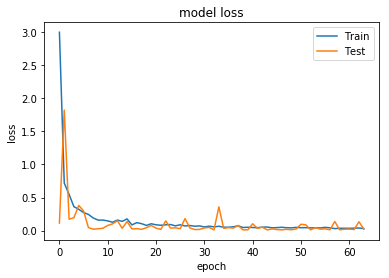

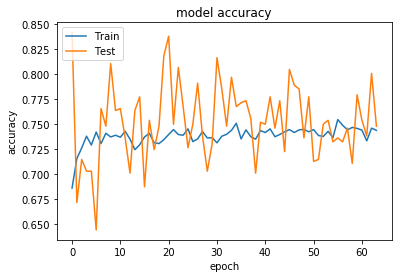

In [5]:
################################################################################
plt.plot(histories.history['loss'])
plt.plot(histories.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.plot(histories.history['acc'])
plt.plot(histories.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [6]:
################################################################################
test_input  = val_data
test_output = val_output
predictions = model.predict(test_input).round().astype(int)
print("=== Input ===\n{}".format(test_input))
print("\n=== True Output ===\n{}".format(test_output))
print("\n=== Prediction ===\n{}".format(predictions))
print("\nAvg Difference: {}".format(np.abs(test_output - predictions).mean()))

=== Input ===
[[1 3 4 3 6 1 3 6 7 0]
 [2 8 1 2 5 6 0 8 6 6]
 [4 1 2 6 1 6 8 8 0 2]
 [3 1 6 1 6 0 7 8 4 7]
 [7 1 6 6 8 6 8 1 1 4]
 [1 8 3 8 7 4 2 2 0 0]
 [6 6 2 1 5 0 5 3 7 2]
 [1 4 5 4 6 6 6 1 0 7]
 [2 5 5 1 1 7 1 8 7 6]
 [3 4 2 1 6 3 3 3 2 2]
 [7 6 4 4 0 1 0 7 0 5]
 [6 4 8 2 1 7 4 2 5 4]
 [3 3 5 6 4 8 8 0 0 2]
 [6 2 8 2 3 8 3 8 5 4]
 [1 4 3 8 5 4 1 2 3 6]
 [2 5 3 0 8 1 5 4 4 3]
 [6 6 4 0 6 1 5 4 5 7]
 [0 1 2 3 8 6 4 3 1 7]
 [3 6 5 7 7 4 6 6 8 5]
 [3 2 4 0 1 5 1 6 7 0]
 ..., 
 [4 3 4 2 6 1 6 7 8 8]
 [7 6 8 2 0 6 0 2 8 6]
 [7 5 2 4 1 4 6 8 0 5]
 [4 3 5 7 1 1 6 6 5 8]
 [2 4 0 2 7 0 4 2 7 8]
 [2 8 5 7 2 2 4 1 2 2]
 [4 6 0 2 8 5 4 6 4 4]
 [0 6 4 3 6 1 1 0 8 2]
 [2 4 5 1 2 4 6 1 6 5]
 [7 8 8 4 7 0 7 7 8 4]
 [6 0 6 7 3 8 3 6 3 0]
 [2 2 5 4 1 2 0 4 4 7]
 [2 4 6 5 5 8 8 7 3 2]
 [3 6 5 0 6 8 8 3 4 2]
 [8 5 6 3 7 1 0 0 3 7]
 [5 6 2 7 6 5 3 6 7 0]
 [8 0 1 8 5 0 3 4 0 5]
 [0 8 2 3 6 6 4 8 4 8]
 [2 7 8 5 2 4 2 5 8 4]
 [6 4 6 4 6 8 1 7 6 4]]

=== True Output ===
[[ 1  3  4  3  6  1  3  6  7  0 33 31

### Loss is custom

In [7]:
################################################################################
class LossFunction:
    def __init__(self, output_shape) -> None:
        self.output_shape = output_shape
        
    def __call__(self) -> Callable[[Tensor, Tensor], Tensor]:
        def custom_loss(y_true: Tensor, y_pred: Tensor) -> Tensor:
            loss = None  # Loss tensor to be returned.
            half = self.output_shape[1] // 2  # Midpoint index.
            left_sum = y_pred[:, :half].sum(-1)  # Sum of left half.
            for i in range(half):
                right = y_pred[:, half + i]
                left  = y_pred[:, i]
                diff  = (right - (left_sum - left))**2
                loss  = diff if loss is None else loss + diff
            mse = ((y_pred[:, :half] - y_true[:, :half])**2).mean(-1)
            return mse if loss is None else loss + mse
        return custom_loss

A = T.dmatrix("A")
B = T.dmatrix("B")
C = LossFunction(output.shape)()(A, B)
D = theano.function([A, B], C, on_unused_input="ignore")
y_true = output[0:2]
y_pred = output[2:4] 
evaluation = D(y_true, y_pred).round(2)
print("=== True Output ===\n{}".format(y_true))
print("\n=== Prediction ===\n{}".format(y_pred))
print("\n=== Losses ===\n{}".format(evaluation))

=== True Output ===
[[ 4  8  2  5  3  6  2  1  5  0 32 28 34 31 33 30 34 35 31 36]
 [ 6  8  1  8  0  1  5  7  6  3 39 37 44 37 45 44 40 38 39 42]]

=== Prediction ===
[[ 8  3  5  8  6  2  5  2  5  1 37 42 40 37 39 43 40 43 40 44]
 [ 7  1  5  0  1  0  1  3  8  8 27 33 29 34 33 34 33 31 26 26]]

=== Losses ===
[  9.5  19.3]


In [8]:
################################################################################
input_layer  = Input(name="Input", shape=data.shape[1:])
model_layer  = Dense(name="Dense 1", units=512, activation="relu")(input_layer)
model_layer  = Dense(name="Dense 2", units=512, activation="relu")(model_layer)
model_layer  = Dense(name="Dense 3", units=512, activation="relu")(model_layer)
output_layer = Dense(name="Output", units=output.shape[1])(model_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(
    loss=LossFunction(output.shape)(), optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10)                0         
_________________________________________________________________
Dense 1 (Dense)              (None, 512)               5632      
_________________________________________________________________
Dense 2 (Dense)              (None, 512)               262656    
_________________________________________________________________
Dense 3 (Dense)              (None, 512)               262656    
_________________________________________________________________
Output (Dense)               (None, 20)                10260     
Total params: 541,204
Trainable params: 541,204
Non-trainable params: 0
_________________________________________________________________


In [9]:
################################################################################
np.random.seed(1010)
histories = model.fit(data, output, epochs=64, batch_size=1, verbose=2,
                     validation_data=(val_data, val_output))

Train on 4096 samples, validate on 512 samples
Epoch 1/64
6s - loss: 10.1946 - acc: 0.4634 - val_loss: 2.6695 - val_acc: 0.6855
Epoch 2/64
5s - loss: 4.7339 - acc: 0.6138 - val_loss: 1.6766 - val_acc: 0.6738
Epoch 3/64
5s - loss: 3.7887 - acc: 0.6504 - val_loss: 1.7606 - val_acc: 0.7070
Epoch 4/64
5s - loss: 3.2649 - acc: 0.6611 - val_loss: 0.4988 - val_acc: 0.6973
Epoch 5/64
5s - loss: 2.7540 - acc: 0.6626 - val_loss: 1.4838 - val_acc: 0.6426
Epoch 6/64
5s - loss: 2.6535 - acc: 0.6748 - val_loss: 8.7702 - val_acc: 0.6465
Epoch 7/64
5s - loss: 2.2945 - acc: 0.6814 - val_loss: 1.6153 - val_acc: 0.6816
Epoch 8/64
5s - loss: 2.3318 - acc: 0.6841 - val_loss: 0.4878 - val_acc: 0.7188
Epoch 9/64
5s - loss: 1.9028 - acc: 0.7014 - val_loss: 0.3676 - val_acc: 0.7324
Epoch 10/64
5s - loss: 1.6298 - acc: 0.7217 - val_loss: 1.7516 - val_acc: 0.6738
Epoch 11/64
5s - loss: 1.5654 - acc: 0.7126 - val_loss: 0.2020 - val_acc: 0.7383
Epoch 12/64
5s - loss: 1.4320 - acc: 0.7231 - val_loss: 0.4478 - val_a

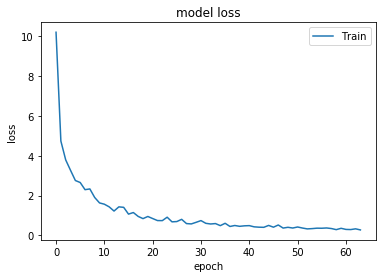

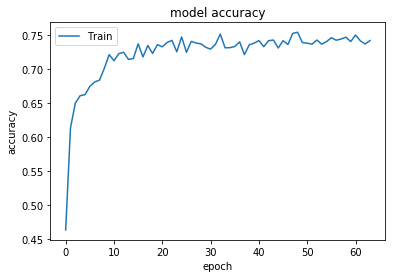

In [10]:
################################################################################
plt.plot(histories.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.plot(histories.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [11]:
################################################################################
test_input  = val_data
test_output = val_output
predictions = model.predict(test_input).round().astype(int)
print("=== Input ===\n{}".format(test_input))
print("\n=== True Output ===\n{}".format(test_output))
print("\n=== Prediction ===\n{}".format(predictions))
print("\nAvg Difference: {}".format(np.abs(test_output - predictions).mean()))

=== Input ===
[[1 3 4 3 6 1 3 6 7 0]
 [2 8 1 2 5 6 0 8 6 6]
 [4 1 2 6 1 6 8 8 0 2]
 [3 1 6 1 6 0 7 8 4 7]
 [7 1 6 6 8 6 8 1 1 4]
 [1 8 3 8 7 4 2 2 0 0]
 [6 6 2 1 5 0 5 3 7 2]
 [1 4 5 4 6 6 6 1 0 7]
 [2 5 5 1 1 7 1 8 7 6]
 [3 4 2 1 6 3 3 3 2 2]
 [7 6 4 4 0 1 0 7 0 5]
 [6 4 8 2 1 7 4 2 5 4]
 [3 3 5 6 4 8 8 0 0 2]
 [6 2 8 2 3 8 3 8 5 4]
 [1 4 3 8 5 4 1 2 3 6]
 [2 5 3 0 8 1 5 4 4 3]
 [6 6 4 0 6 1 5 4 5 7]
 [0 1 2 3 8 6 4 3 1 7]
 [3 6 5 7 7 4 6 6 8 5]
 [3 2 4 0 1 5 1 6 7 0]
 ..., 
 [4 3 4 2 6 1 6 7 8 8]
 [7 6 8 2 0 6 0 2 8 6]
 [7 5 2 4 1 4 6 8 0 5]
 [4 3 5 7 1 1 6 6 5 8]
 [2 4 0 2 7 0 4 2 7 8]
 [2 8 5 7 2 2 4 1 2 2]
 [4 6 0 2 8 5 4 6 4 4]
 [0 6 4 3 6 1 1 0 8 2]
 [2 4 5 1 2 4 6 1 6 5]
 [7 8 8 4 7 0 7 7 8 4]
 [6 0 6 7 3 8 3 6 3 0]
 [2 2 5 4 1 2 0 4 4 7]
 [2 4 6 5 5 8 8 7 3 2]
 [3 6 5 0 6 8 8 3 4 2]
 [8 5 6 3 7 1 0 0 3 7]
 [5 6 2 7 6 5 3 6 7 0]
 [8 0 1 8 5 0 3 4 0 5]
 [0 8 2 3 6 6 4 8 4 8]
 [2 7 8 5 2 4 2 5 8 4]
 [6 4 6 4 6 8 1 7 6 4]]

=== True Output ===
[[ 1  3  4  3  6  1  3  6  7  0 33 31

### Loss is custom and input tensor is introduced

In [12]:
################################################################################
rightside_output = output[:, output.shape[1] // 2:]
rightside_val_output = val_output[:, output.shape[1] // 2:]
print("=== Input Matrix ===\n{}".format(data))
print("\n=== Output Matrix ===\n{}".format(rightside_output))

=== Input Matrix ===
[[4 8 2 5 3 6 2 1 5 0]
 [6 8 1 8 0 1 5 7 6 3]
 [8 3 5 8 6 2 5 2 5 1]
 [7 1 5 0 1 0 1 3 8 8]
 [8 8 8 7 3 6 2 3 4 6]
 [0 4 7 2 4 8 1 1 7 1]
 [1 8 7 1 2 1 7 7 4 5]
 [3 5 5 6 6 8 0 0 2 7]
 [7 6 1 3 6 5 8 1 2 6]
 [5 5 5 0 1 7 5 0 4 5]
 [3 7 4 8 6 3 5 5 2 6]
 [7 0 8 6 5 2 0 4 3 8]
 [5 7 2 3 6 6 2 2 7 7]
 [2 8 0 0 8 1 1 8 0 8]
 [8 0 3 3 2 0 6 3 6 4]
 [2 5 0 5 0 7 5 5 4 0]
 [8 6 0 4 2 5 2 8 8 7]
 [1 1 8 2 0 8 2 0 5 4]
 [8 6 4 7 2 1 1 8 0 2]
 [1 3 0 6 3 7 7 2 4 1]
 ..., 
 [2 8 7 2 6 7 4 0 3 3]
 [6 1 2 6 1 2 8 8 1 2]
 [0 4 8 3 1 3 6 8 5 7]
 [1 1 4 5 5 7 7 8 8 1]
 [2 5 5 0 6 8 5 1 7 2]
 [7 3 6 8 6 8 4 8 0 0]
 [1 5 1 0 3 0 2 3 8 4]
 [3 5 4 2 4 8 5 2 6 7]
 [0 7 1 3 5 7 2 0 8 6]
 [6 5 3 0 7 7 4 5 4 8]
 [1 8 4 4 7 8 2 5 6 7]
 [7 7 3 8 2 3 3 3 7 4]
 [2 0 0 6 7 1 3 5 8 3]
 [8 2 8 6 6 4 0 7 6 4]
 [3 8 7 6 2 8 4 6 1 5]
 [6 6 7 0 1 6 8 4 1 8]
 [5 4 0 7 4 5 0 8 5 1]
 [1 5 5 7 0 5 1 3 4 8]
 [3 8 6 6 8 6 5 3 8 2]
 [2 7 5 0 0 5 0 0 0 6]]

=== Output Matrix ===
[[32 28 34 31 33 30 34 35 31

In [18]:
################################################################################
class InputTensorLossFunction:
    def __init__(self, output_shape, input_tensor: Tensor) -> None:
        self.output_shape = output_shape
        self.input_tensor = input_tensor
        
    def __call__(self) -> Callable[[Tensor, Tensor], Tensor]:
        def custom_loss(y_true: Tensor, y_pred: Tensor) -> Tensor:
            loss = None  # Loss tensor to be returned.
            left_sum = self.input_tensor.sum(-1)
            for i in range(self.output_shape[1]):
                right = y_pred[:, i]
                left  = self.input_tensor[:, i]
                diff  = (right - (left_sum - left))**2
                loss  = diff if loss is None else loss + diff
            return loss
        return custom_loss

A = T.dmatrix("A")
B = T.dmatrix("B")
C = InputTensorLossFunction(rightside_output.shape, A)()(A, B)
D = theano.function([A, B], C, on_unused_input="ignore")
y_true = data[0:2]
y_pred = rightside_output[0:2] 
evaluation = D(y_true, y_pred).round(2)
print("=== Input ===\n{}".format(y_true))
print("\n=== Prediction ===\n{}".format(y_pred))
print("\n=== Losses ===\n{}".format(evaluation))

=== Input ===
[[4 8 2 5 3 6 2 1 5 0]
 [6 8 1 8 0 1 5 7 6 3]]

=== Prediction ===
[[32 28 34 31 33 30 34 35 31 36]
 [39 37 44 37 45 44 40 38 39 42]]

=== Losses ===
[ 0.  0.]


In [14]:
################################################################################
input_layer  = Input(name="Input", shape=data.shape[1:])
model_layer  = Dense(name="Dense 1", units=512, activation="relu")(input_layer)
model_layer  = Dense(name="Dense 2", units=512, activation="relu")(model_layer)
model_layer  = Dense(name="Dense 3", units=512, activation="relu")(model_layer)
output_layer = Dense(name="Output", units=rightside_output.shape[1])(model_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(
    loss=InputTensorLossFunction(rightside_output.shape, input_layer)(),
    optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 10)                0         
_________________________________________________________________
Dense 1 (Dense)              (None, 512)               5632      
_________________________________________________________________
Dense 2 (Dense)              (None, 512)               262656    
_________________________________________________________________
Dense 3 (Dense)              (None, 512)               262656    
_________________________________________________________________
Output (Dense)               (None, 10)                5130      
Total params: 536,074
Trainable params: 536,074
Non-trainable params: 0
_________________________________________________________________


In [15]:
################################################################################
np.random.seed(1010)
histories = model.fit(
    data, rightside_output, epochs=64, batch_size=1, verbose=2,
    validation_data=(val_data, rightside_val_output))

Train on 4096 samples, validate on 512 samples
Epoch 1/64
4s - loss: 47.8392 - acc: 0.6697 - val_loss: 1.7204 - val_acc: 0.7617
Epoch 2/64
4s - loss: 9.3404 - acc: 0.7126 - val_loss: 0.9141 - val_acc: 0.7754
Epoch 3/64
5s - loss: 8.3769 - acc: 0.7048 - val_loss: 1.3329 - val_acc: 0.7734
Epoch 4/64
4s - loss: 5.4583 - acc: 0.7217 - val_loss: 3.7718 - val_acc: 0.7051
Epoch 5/64
4s - loss: 4.2352 - acc: 0.7266 - val_loss: 1.2680 - val_acc: 0.8047
Epoch 6/64
4s - loss: 3.7161 - acc: 0.7361 - val_loss: 2.2335 - val_acc: 0.7559
Epoch 7/64
5s - loss: 2.9375 - acc: 0.7310 - val_loss: 1.8149 - val_acc: 0.7305
Epoch 8/64
4s - loss: 2.8862 - acc: 0.7395 - val_loss: 0.4888 - val_acc: 0.6953
Epoch 9/64
4s - loss: 2.6764 - acc: 0.7405 - val_loss: 1.0849 - val_acc: 0.7539
Epoch 10/64
4s - loss: 2.1624 - acc: 0.7371 - val_loss: 0.6228 - val_acc: 0.8008
Epoch 11/64
4s - loss: 1.8487 - acc: 0.7395 - val_loss: 1.3928 - val_acc: 0.7051
Epoch 12/64
4s - loss: 1.8190 - acc: 0.7344 - val_loss: 2.1506 - val_a

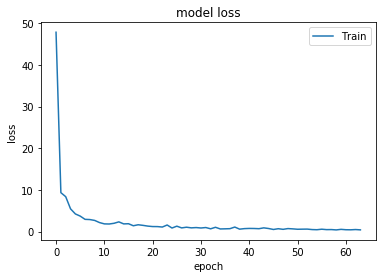

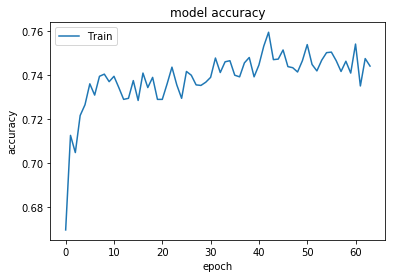

In [16]:
################################################################################
plt.plot(histories.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
plt.plot(histories.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
################################################################################
test_input  = val_data
test_output = rightside_val_output
predictions = model.predict(test_input).round().astype(int)
print("=== Input ===\n{}".format(test_input))
print("\n=== True Output ===\n{}".format(test_output))
print("\n=== Prediction ===\n{}".format(predictions))
print("\nAvg Difference: {}".format(np.abs(test_output - predictions).mean()))

=== Input ===
[[1 3 4 3 6 1 3 6 7 0]
 [2 8 1 2 5 6 0 8 6 6]
 [4 1 2 6 1 6 8 8 0 2]
 [3 1 6 1 6 0 7 8 4 7]
 [7 1 6 6 8 6 8 1 1 4]
 [1 8 3 8 7 4 2 2 0 0]
 [6 6 2 1 5 0 5 3 7 2]
 [1 4 5 4 6 6 6 1 0 7]
 [2 5 5 1 1 7 1 8 7 6]
 [3 4 2 1 6 3 3 3 2 2]
 [7 6 4 4 0 1 0 7 0 5]
 [6 4 8 2 1 7 4 2 5 4]
 [3 3 5 6 4 8 8 0 0 2]
 [6 2 8 2 3 8 3 8 5 4]
 [1 4 3 8 5 4 1 2 3 6]
 [2 5 3 0 8 1 5 4 4 3]
 [6 6 4 0 6 1 5 4 5 7]
 [0 1 2 3 8 6 4 3 1 7]
 [3 6 5 7 7 4 6 6 8 5]
 [3 2 4 0 1 5 1 6 7 0]
 ..., 
 [4 3 4 2 6 1 6 7 8 8]
 [7 6 8 2 0 6 0 2 8 6]
 [7 5 2 4 1 4 6 8 0 5]
 [4 3 5 7 1 1 6 6 5 8]
 [2 4 0 2 7 0 4 2 7 8]
 [2 8 5 7 2 2 4 1 2 2]
 [4 6 0 2 8 5 4 6 4 4]
 [0 6 4 3 6 1 1 0 8 2]
 [2 4 5 1 2 4 6 1 6 5]
 [7 8 8 4 7 0 7 7 8 4]
 [6 0 6 7 3 8 3 6 3 0]
 [2 2 5 4 1 2 0 4 4 7]
 [2 4 6 5 5 8 8 7 3 2]
 [3 6 5 0 6 8 8 3 4 2]
 [8 5 6 3 7 1 0 0 3 7]
 [5 6 2 7 6 5 3 6 7 0]
 [8 0 1 8 5 0 3 4 0 5]
 [0 8 2 3 6 6 4 8 4 8]
 [2 7 8 5 2 4 2 5 8 4]
 [6 4 6 4 6 8 1 7 6 4]]

=== True Output ===
[[33 31 30 31 28 33 31 28 27 34]
 [42